# 01 - Dataset Overview and Exploration

This notebook provides a comprehensive overview of the UCI Individual Household Electric Power Consumption dataset.

## Objectives
1. Load and examine the raw dataset
2. Understand data structure, types, and basic statistics
3. Identify data quality issues (missing values, outliers)
4. Visualize temporal patterns at different resolutions
5. Document key findings for modeling decisions

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

from src.data.load_data import load_raw

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Dataset

In [2]:
# Load raw data
data_path = '../dataset/household_power_consumption.txt'
df = load_raw(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"Total duration: {(df['DateTime'].max() - df['DateTime'].min()).days} days")

Dataset shape: (2075259, 8)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Total duration: 1441 days


## 2. Data Structure and Types

In [3]:
# Display first few rows
df.head(10)

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0
8,2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0
9,2006-12-16 17:33:00,3.662,0.510,233.86,15.8,0.0,2.0,16.0


In [4]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   DateTime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [5]:
# Column descriptions
column_descriptions = {
    'DateTime': 'Date and time (combined from Date and Time columns)',
    'Global_active_power': 'Household global minute-averaged active power (kilowatts)',
    'Global_reactive_power': 'Household global minute-averaged reactive power (kilowatts)',
    'Voltage': 'Minute-averaged voltage (volts)',
    'Global_intensity': 'Household global minute-averaged current intensity (amperes)',
    'Sub_metering_1': 'Energy sub-metering No. 1 - Kitchen (watt-hours)',
    'Sub_metering_2': 'Energy sub-metering No. 2 - Laundry (watt-hours)',
    'Sub_metering_3': 'Energy sub-metering No. 3 - Water heater & AC (watt-hours)'
}

pd.DataFrame(column_descriptions.items(), columns=['Column', 'Description'])

,Column,Description
0,DateTime,Date and time (combined from Date and Time col...
1,Global_active_power,Household global minute-averaged active power ...
2,Global_reactive_power,Household global minute-averaged reactive powe...
3,Voltage,Minute-averaged voltage (volts)
4,Global_intensity,Household global minute-averaged current inten...
5,Sub_metering_1,Energy sub-metering No. 1 - Kitchen (watt-hours)
6,Sub_metering_2,Energy sub-metering No. 2 - Laundry (watt-hours)
7,Sub_metering_3,Energy sub-metering No. 3 - Water heater & AC ...


## 3. Basic Statistics

In [6]:
# Summary statistics
df.describe()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,2008-12-06 07:12:59.999994112,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
min,2006-12-16 17:24:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2007-12-12 00:18:30,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2008-12-06 07:13:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,2009-12-01 14:07:30,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,2010-11-26 21:02:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01
std,NaN,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00


## 4. Missing Values Analysis

In [7]:
# Missing values count and percentage
missing_stats = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_stats)

                       Missing Count  Missing Percentage
Global_active_power            25979            1.251844
Global_reactive_power          25979            1.251844
Voltage                        25979            1.251844
Global_intensity               25979            1.251844
Sub_metering_1                 25979            1.251844
Sub_metering_2                 25979            1.251844
Sub_metering_3                 25979            1.251844


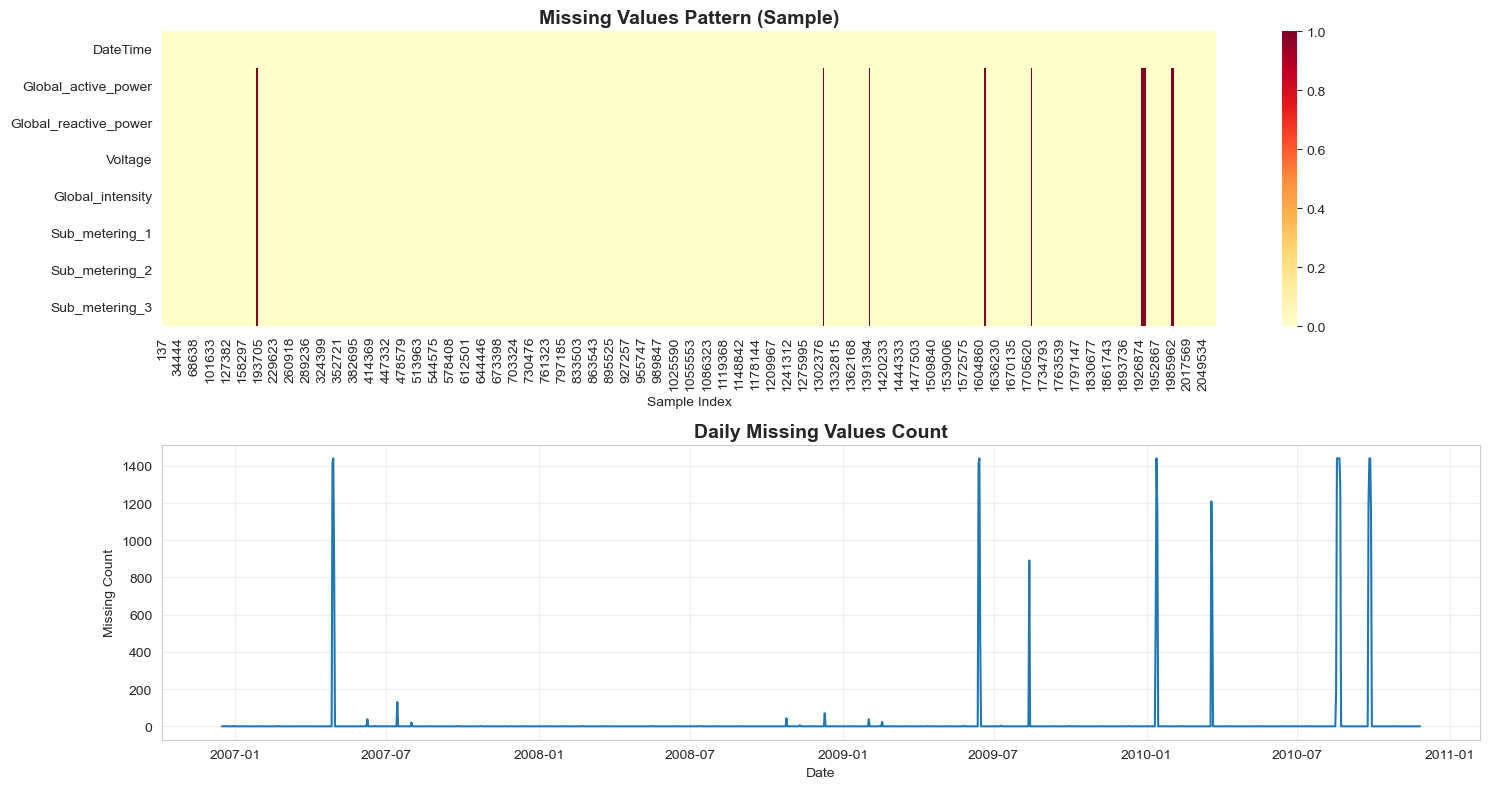

In [8]:
# Visualize missing values pattern
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Missing values heatmap (sample)
sample_size = 10000
sample_idx = np.random.choice(df.index, size=min(sample_size, len(df)), replace=False)
sample_idx = sorted(sample_idx)

axes[0].set_title('Missing Values Pattern (Sample)', fontsize=14, fontweight='bold')
sns.heatmap(df.loc[sample_idx].isnull().T, cbar=True, cmap='YlOrRd', ax=axes[0])
axes[0].set_xlabel('Sample Index')

# Missing values over time
df_temp = df.copy()
df_temp['date'] = df_temp['DateTime'].dt.date
daily_missing = df_temp.groupby('date')['Global_active_power'].apply(lambda x: x.isnull().sum())

axes[1].plot(daily_missing.index, daily_missing.values)
axes[1].set_title('Daily Missing Values Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Missing Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Target Variable Analysis: Global Active Power

In [9]:
# Focus on target variable
target = 'Global_active_power'
target_data = df[target].dropna()

print(f"Target variable: {target}")
print(f"Valid observations: {len(target_data):,}")
print(f"Missing observations: {df[target].isnull().sum():,}")
print(f"\nStatistics:")
print(target_data.describe())

Target variable: Global_active_power
Valid observations: 2,049,280
Missing observations: 25,979

Statistics:
count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64


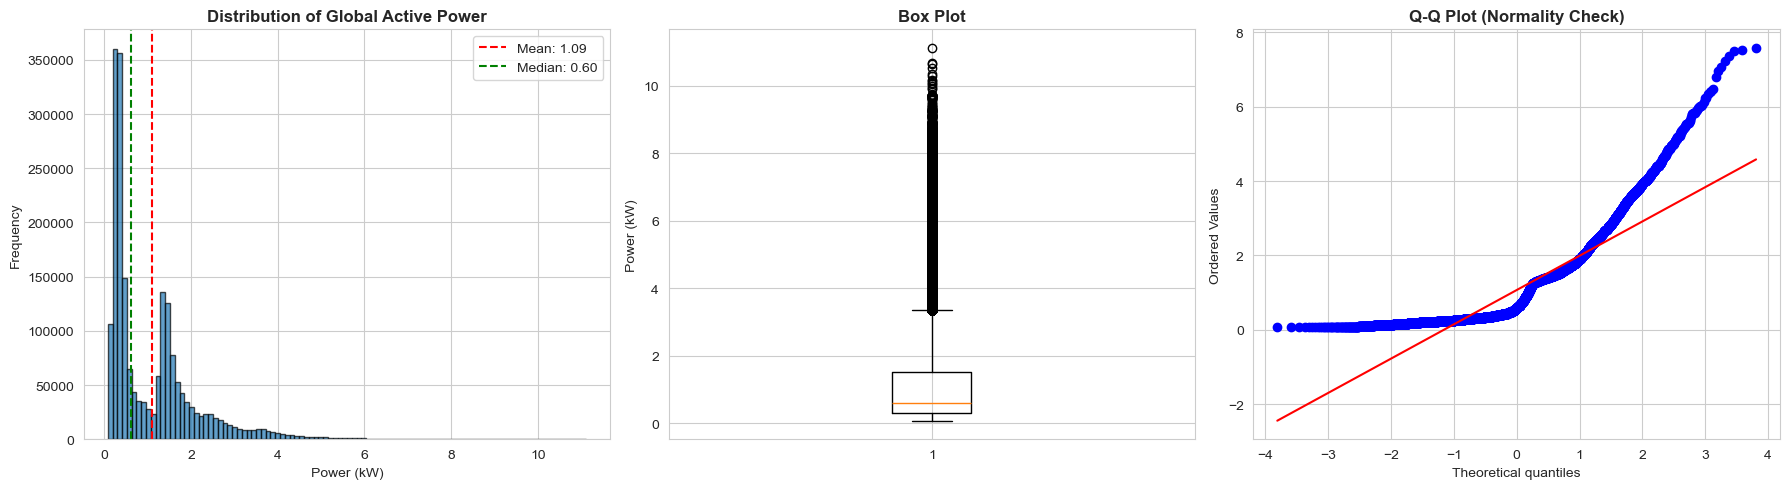

In [10]:
# Distribution of target variable
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(target_data, bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Global Active Power', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Power (kW)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(target_data.mean(), color='red', linestyle='--', label=f'Mean: {target_data.mean():.2f}')
axes[0].axvline(target_data.median(), color='green', linestyle='--', label=f'Median: {target_data.median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(target_data)
axes[1].set_title('Box Plot', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Power (kW)')

# Q-Q plot for normality check
from scipy import stats
stats.probplot(target_data.sample(min(10000, len(target_data))), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Time Series Visualization

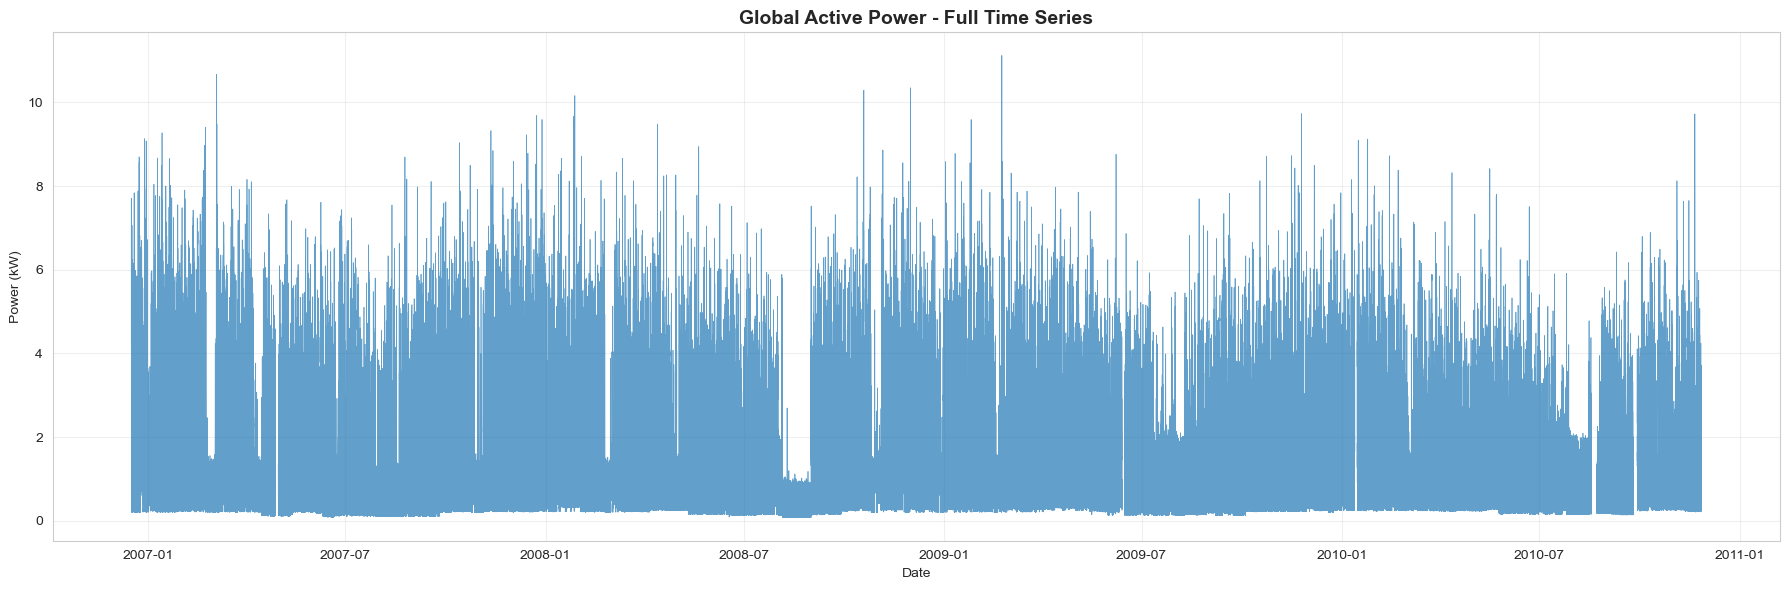

In [11]:
# Full time series
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['DateTime'], df[target], linewidth=0.5, alpha=0.7)
ax.set_title('Global Active Power - Full Time Series', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

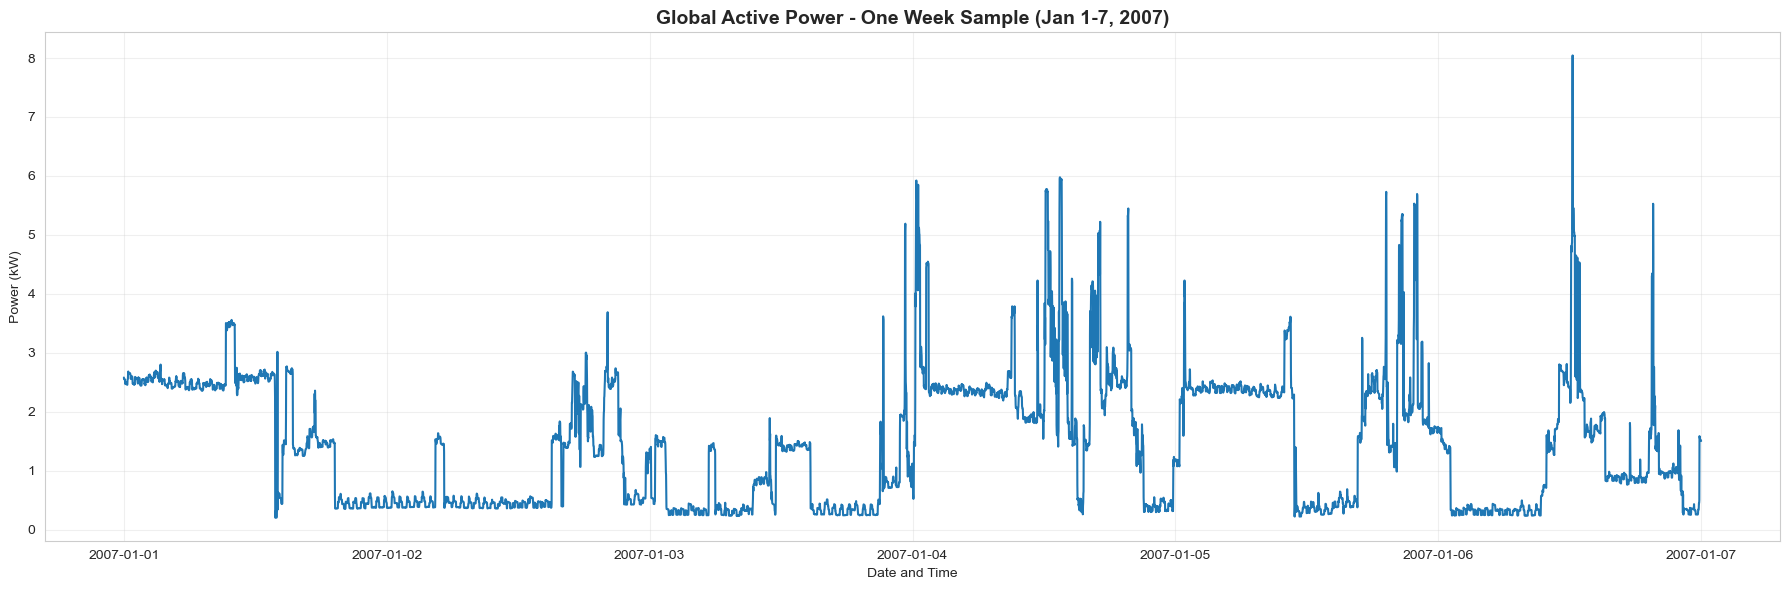

In [12]:
# Zoom into one week
week_sample = df[df['DateTime'].between('2007-01-01', '2007-01-07')]

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(week_sample['DateTime'], week_sample[target], linewidth=1.5)
ax.set_title('Global Active Power - One Week Sample (Jan 1-7, 2007)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date and Time')
ax.set_ylabel('Power (kW)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

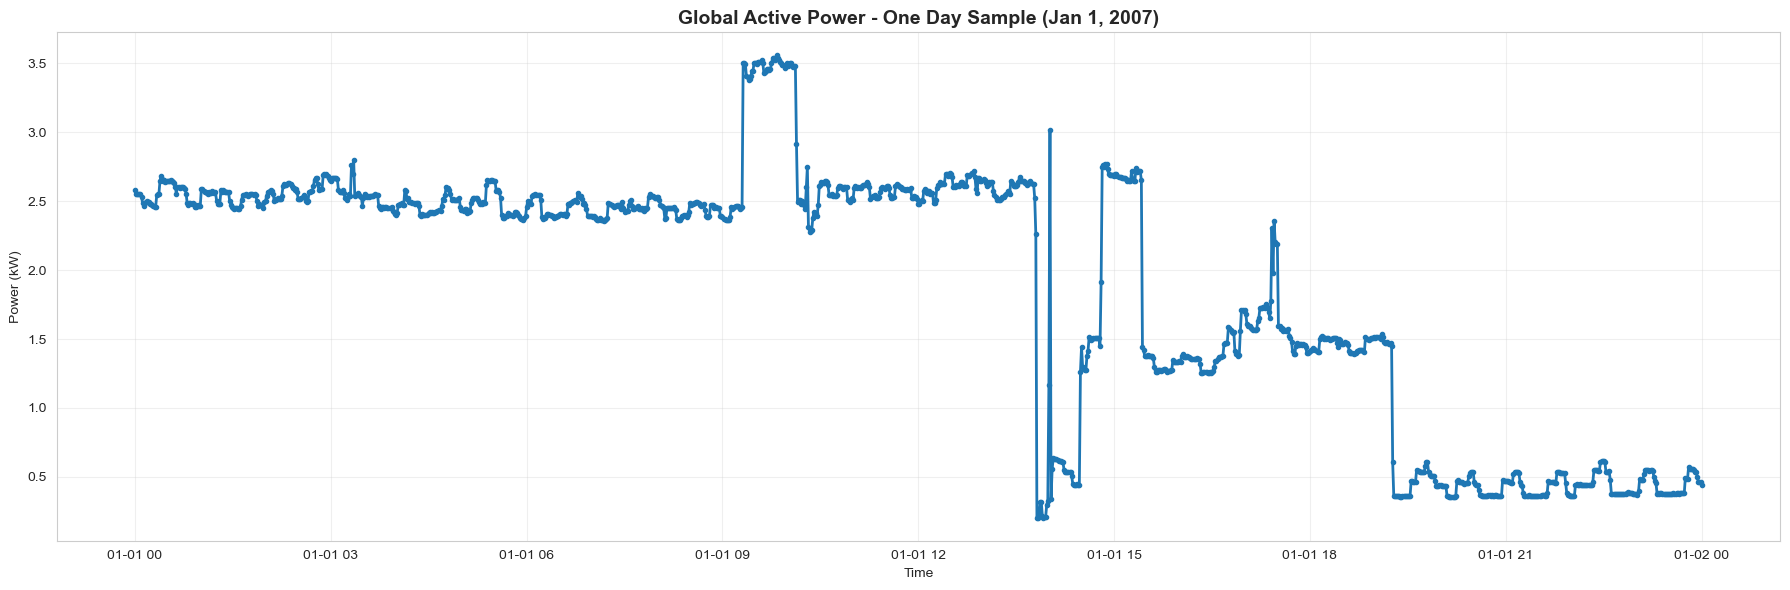

In [13]:
# Zoom into one day
day_sample = df[df['DateTime'].between('2007-01-01', '2007-01-02')]

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(day_sample['DateTime'], day_sample[target], linewidth=2, marker='o', markersize=3)
ax.set_title('Global Active Power - One Day Sample (Jan 1, 2007)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Power (kW)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Temporal Patterns Analysis

In [14]:
# Add temporal features for analysis
df_analysis = df.dropna(subset=[target]).copy()
df_analysis['hour'] = df_analysis['DateTime'].dt.hour
df_analysis['dayofweek'] = df_analysis['DateTime'].dt.dayofweek
df_analysis['month'] = df_analysis['DateTime'].dt.month
df_analysis['year'] = df_analysis['DateTime'].dt.year

print(f"Analysis dataset: {len(df_analysis):,} observations")

Analysis dataset: 2,049,280 observations


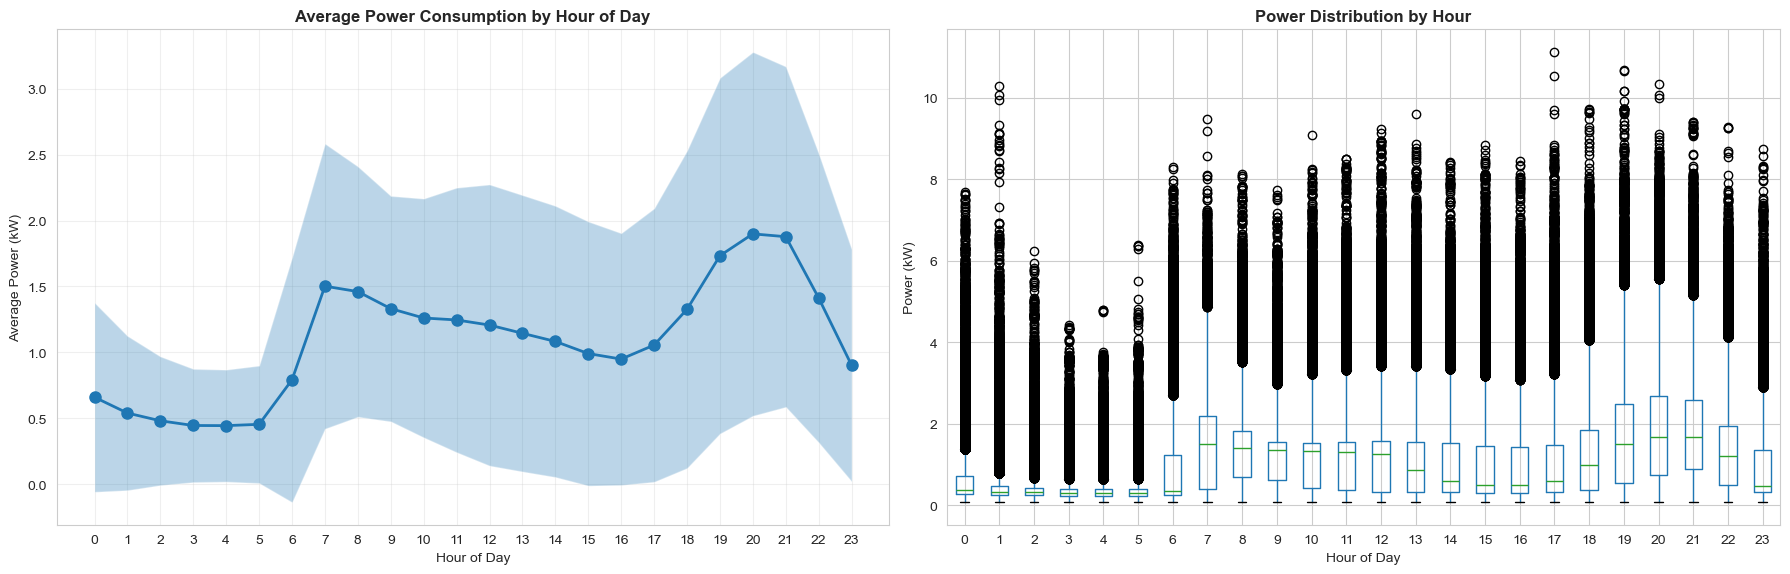

In [15]:
# Hourly patterns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

hourly_avg = df_analysis.groupby('hour')[target].mean()
hourly_std = df_analysis.groupby('hour')[target].std()

axes[0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8)
axes[0].fill_between(hourly_avg.index, 
                      hourly_avg.values - hourly_std.values, 
                      hourly_avg.values + hourly_std.values, 
                      alpha=0.3)
axes[0].set_title('Average Power Consumption by Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Power (kW)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

# Box plot by hour
df_analysis.boxplot(column=target, by='hour', ax=axes[1], figsize=(18, 6))
axes[1].set_title('Power Distribution by Hour', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Power (kW)')
plt.suptitle('')

plt.tight_layout()
plt.show()

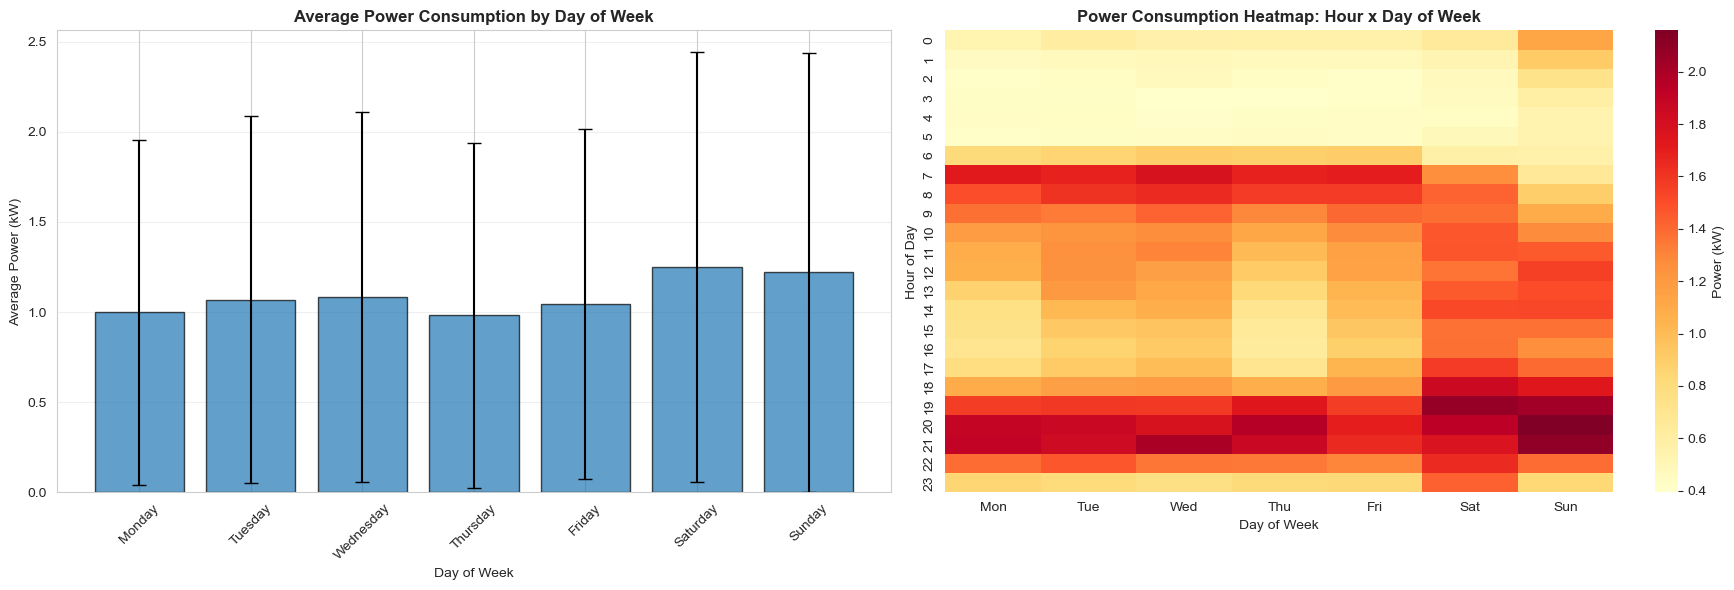

In [16]:
# Day of week patterns
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

dow_avg = df_analysis.groupby('dayofweek')[target].mean()
dow_std = df_analysis.groupby('dayofweek')[target].std()

axes[0].bar(dow_avg.index, dow_avg.values, yerr=dow_std.values, capsize=5, alpha=0.7, edgecolor='black')
axes[0].set_title('Average Power Consumption by Day of Week', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Power (kW)')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names, rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Heatmap: Hour x Day of Week
pivot_table = df_analysis.pivot_table(values=target, index='hour', columns='dayofweek', aggfunc='mean')
sns.heatmap(pivot_table, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Power (kW)'})
axes[1].set_title('Power Consumption Heatmap: Hour x Day of Week', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Hour of Day')
axes[1].set_xticklabels([day[:3] for day in day_names])

plt.tight_layout()
plt.show()

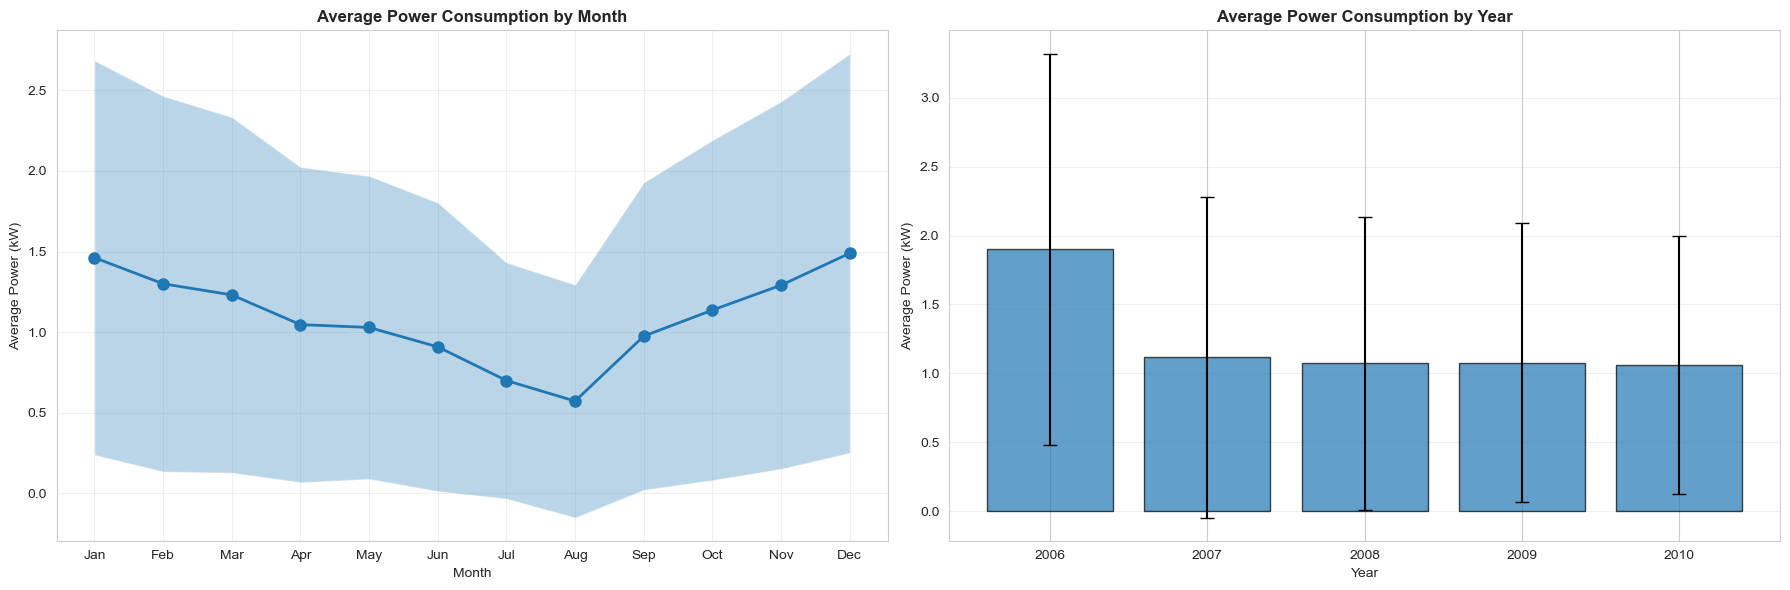

In [17]:
# Monthly and seasonal patterns
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

monthly_avg = df_analysis.groupby('month')[target].mean()
monthly_std = df_analysis.groupby('month')[target].std()

axes[0].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8)
axes[0].fill_between(monthly_avg.index, 
                      monthly_avg.values - monthly_std.values, 
                      monthly_avg.values + monthly_std.values, 
                      alpha=0.3)
axes[0].set_title('Average Power Consumption by Month', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average Power (kW)')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(month_names)
axes[0].grid(True, alpha=0.3)

# Yearly comparison
yearly_avg = df_analysis.groupby('year')[target].mean()
yearly_std = df_analysis.groupby('year')[target].std()

axes[1].bar(yearly_avg.index, yearly_avg.values, yerr=yearly_std.values, capsize=5, alpha=0.7, edgecolor='black')
axes[1].set_title('Average Power Consumption by Year', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Power (kW)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Sub-metering Analysis

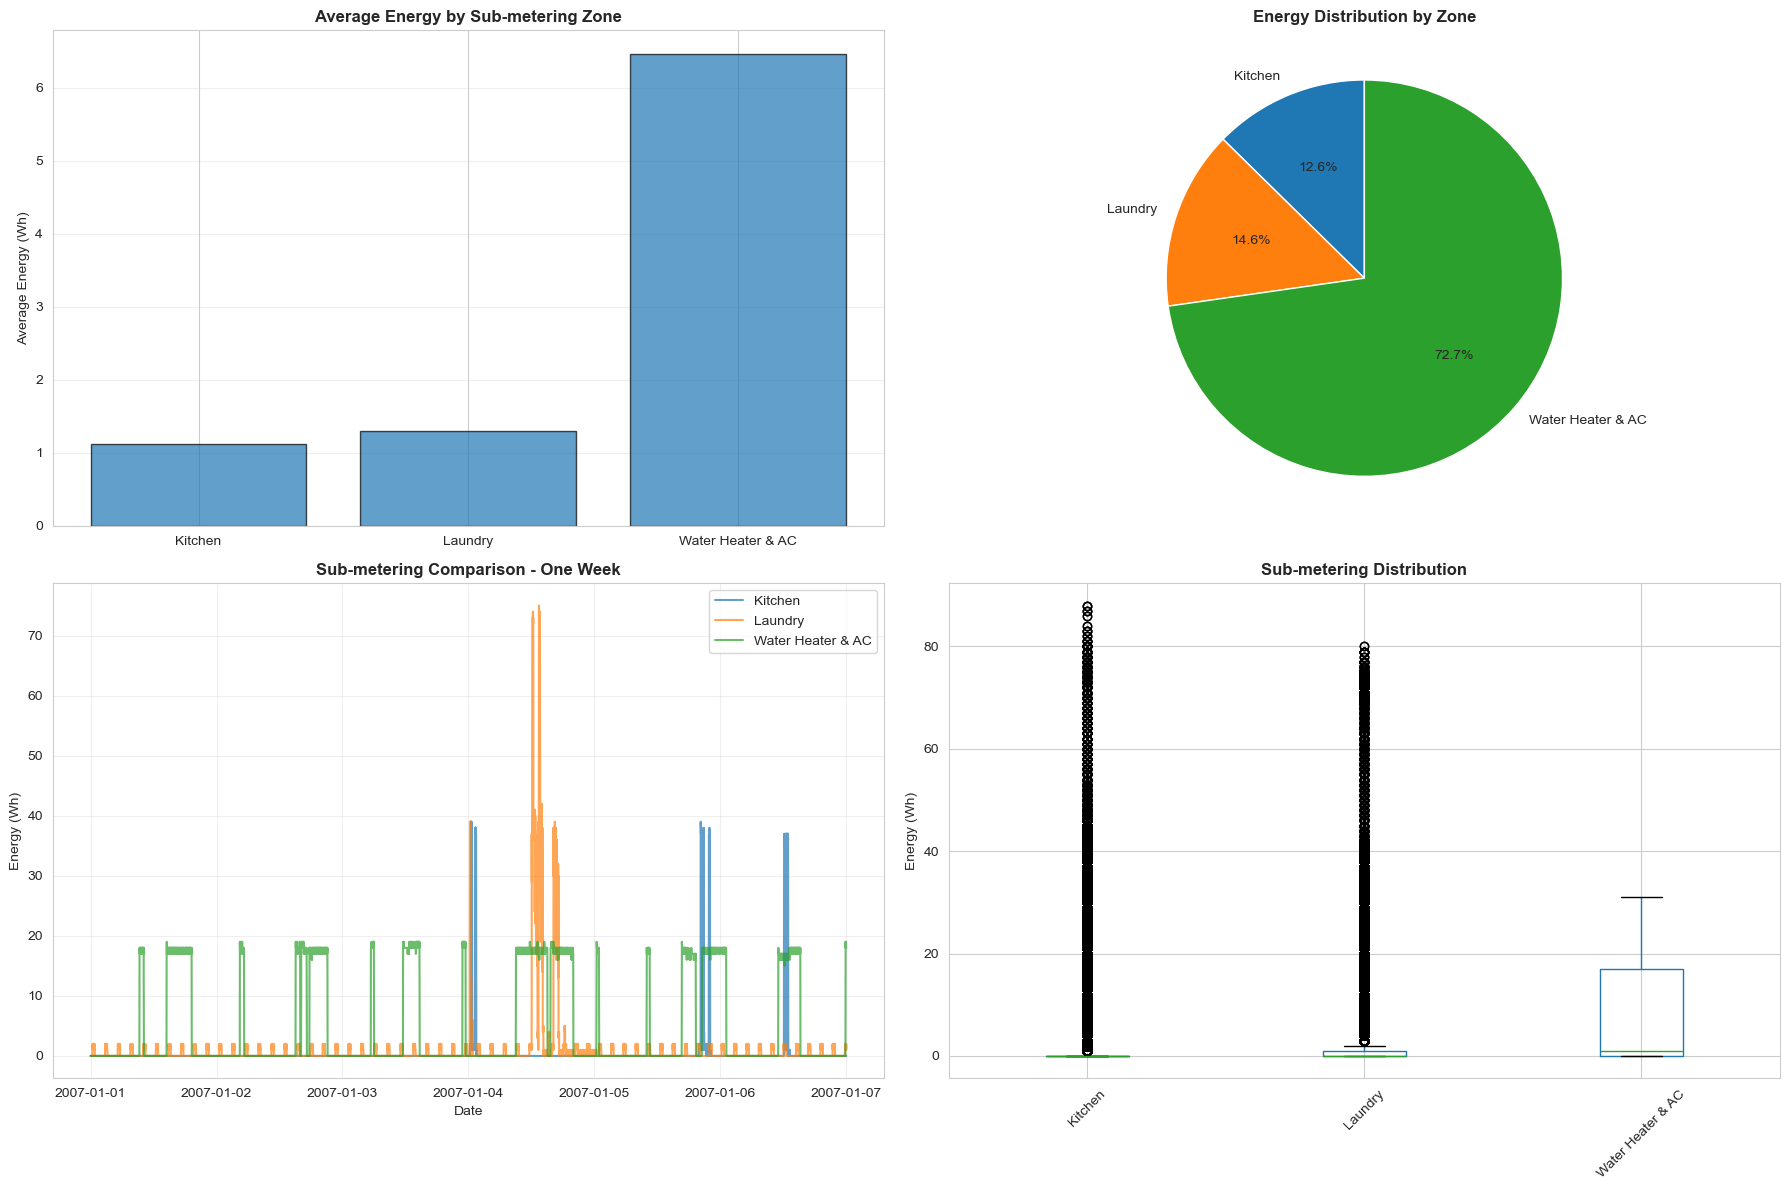

In [18]:
# Sub-metering variables
submetering_cols = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
submetering_labels = ['Kitchen', 'Laundry', 'Water Heater & AC']

# Calculate average contribution
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Average values
avg_values = [df[col].mean() for col in submetering_cols]
axes[0, 0].bar(submetering_labels, avg_values, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Average Energy by Sub-metering Zone', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Average Energy (Wh)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Pie chart of contribution
axes[0, 1].pie(avg_values, labels=submetering_labels, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Energy Distribution by Zone', fontsize=12, fontweight='bold')

# Time series comparison (sample week)
week_sample = df[df['DateTime'].between('2007-01-01', '2007-01-07')]
for col, label in zip(submetering_cols, submetering_labels):
    axes[1, 0].plot(week_sample['DateTime'], week_sample[col], label=label, alpha=0.7, linewidth=1.5)
axes[1, 0].set_title('Sub-metering Comparison - One Week', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Energy (Wh)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Box plots
df[submetering_cols].boxplot(ax=axes[1, 1])
axes[1, 1].set_title('Sub-metering Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xticklabels(submetering_labels, rotation=45)
axes[1, 1].set_ylabel('Energy (Wh)')

plt.tight_layout()
plt.show()

## 9. Correlation Analysis

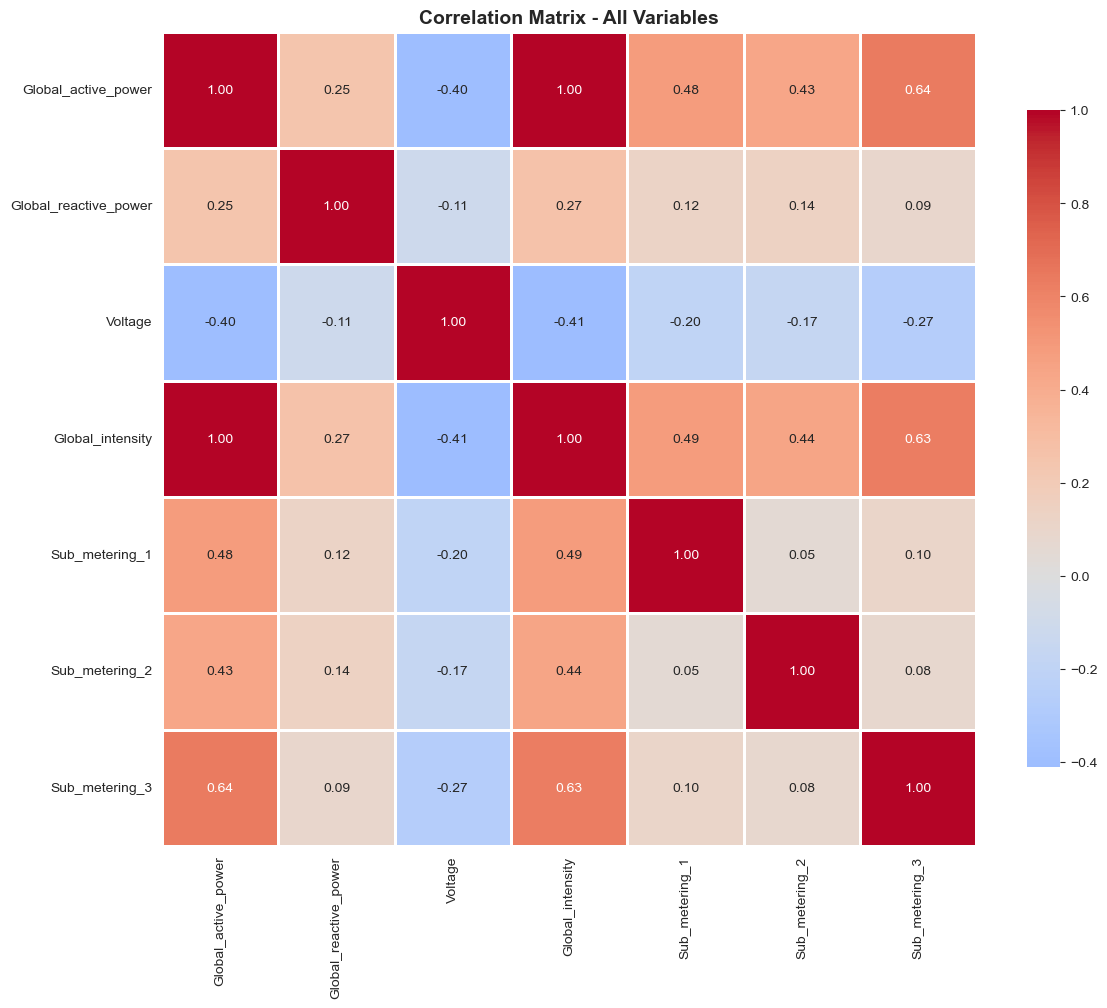

In [19]:
# Correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix - All Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Outlier Detection

In [20]:
# Detect outliers using IQR method
Q1 = target_data.quantile(0.25)
Q3 = target_data.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = target_data[(target_data < lower_bound) | (target_data > upper_bound)]

print(f"Total outliers detected: {len(outliers):,} ({len(outliers)/len(target_data)*100:.2f}%)")
print(f"Lower bound: {lower_bound:.2f} kW")
print(f"Upper bound: {upper_bound:.2f} kW")
print(f"\nOutlier statistics:")
print(outliers.describe())

Total outliers detected: 94,907 (4.63%)
Lower bound: -1.52 kW
Upper bound: 3.36 kW

Outlier statistics:
count    94907.000000
mean         4.302087
std          0.899524
min          3.360000
25%          3.650000
50%          3.994000
75%          4.698000
max         11.122000
Name: Global_active_power, dtype: float64


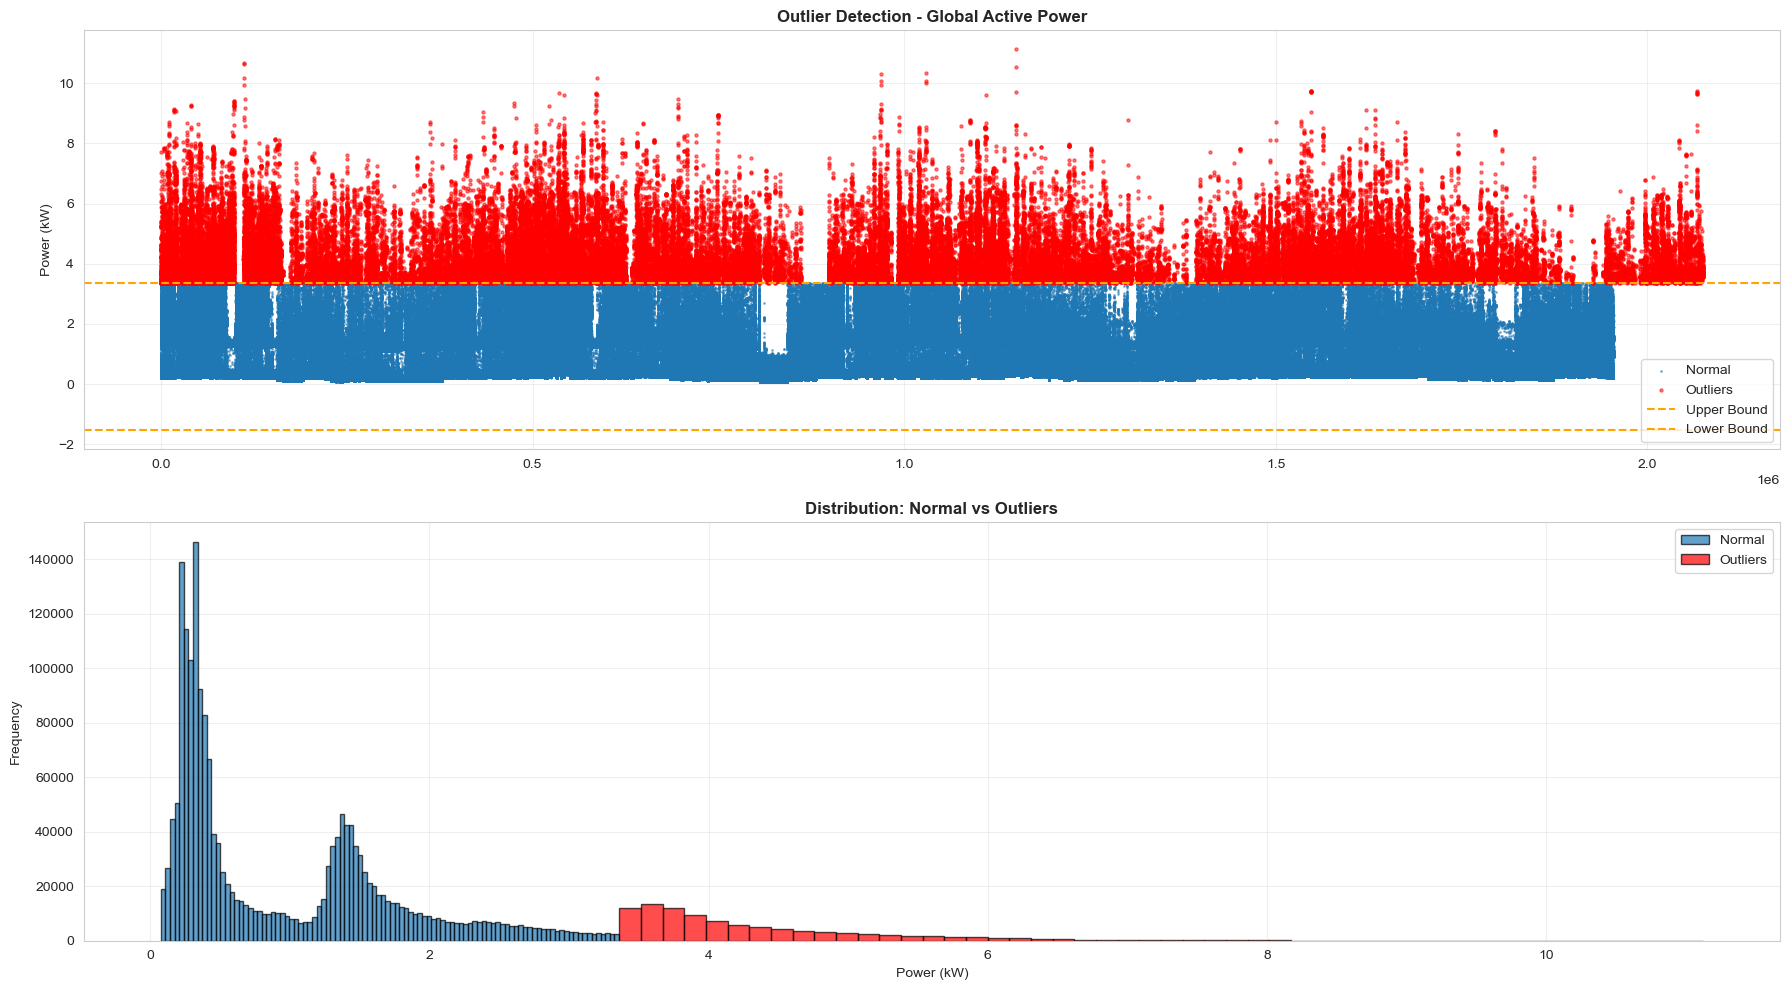

In [21]:
# Visualize outliers
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Scatter plot with outliers highlighted
normal_data = target_data[(target_data >= lower_bound) & (target_data <= upper_bound)]
axes[0].scatter(range(len(normal_data)), normal_data, s=1, alpha=0.5, label='Normal')
axes[0].scatter(outliers.index, outliers, s=5, c='red', alpha=0.5, label='Outliers')
axes[0].axhline(upper_bound, color='orange', linestyle='--', label='Upper Bound')
axes[0].axhline(lower_bound, color='orange', linestyle='--', label='Lower Bound')
axes[0].set_title('Outlier Detection - Global Active Power', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution comparison
axes[1].hist(normal_data, bins=100, alpha=0.7, label='Normal', edgecolor='black')
axes[1].hist(outliers, bins=50, alpha=0.7, label='Outliers', edgecolor='black', color='red')
axes[1].set_title('Distribution: Normal vs Outliers', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Power (kW)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Key Findings and Recommendations

### Data Quality
1. **Missing Values**: ~1.25% of observations contain missing values
2. **Outliers**: Detected using IQR method, primarily representing extreme consumption events
3. **Data Integrity**: Generally high quality with consistent temporal resolution

### Temporal Patterns
1. **Daily Patterns**: Clear diurnal cycle with peak consumption in evenings (18:00-22:00)
2. **Weekly Patterns**: Weekday vs weekend differences observable
3. **Seasonal Patterns**: Higher consumption in winter months (heating) and summer (cooling)
4. **Long-term Trends**: Relatively stable over the 4-year period

### Sub-metering Insights
1. Different consumption patterns across zones
2. Kitchen (Sub_metering_1) shows regular meal-time spikes
3. Water heater & AC (Sub_metering_3) contributes significantly
4. Hierarchical relationship with total consumption

### Modeling Recommendations
1. **Aggregation**: Daily or hourly aggregation recommended to reduce noise
2. **Features**: Include temporal features (hour, day, month), lags, rolling statistics
3. **Missing Values**: Forward-fill for short gaps, interpolation for longer gaps
4. **Outliers**: Keep but flag for robust modeling approaches
5. **Sub-metering**: Consider as additional features or for hierarchical modeling
6. **Seasonality**: Account for multiple seasonal components (daily, weekly, yearly)

### Next Steps
1. Implement preprocessing pipeline (02_eda_preprocessing.ipynb)
2. Create engineered features for modeling
3. Perform time series decomposition
4. Establish train/validation/test splits preserving temporal order

## 12. Save Summary Statistics

In [22]:
# Save key statistics for reporting
summary = {
    'total_observations': len(df),
    'date_range': f"{df['DateTime'].min()} to {df['DateTime'].max()}",
    'duration_days': (df['DateTime'].max() - df['DateTime'].min()).days,
    'missing_percentage': (df[target].isnull().sum() / len(df)) * 100,
    'target_mean': target_data.mean(),
    'target_std': target_data.std(),
    'target_min': target_data.min(),
    'target_max': target_data.max(),
    'outlier_percentage': (len(outliers) / len(target_data)) * 100
}

import json
with open('../reports/dataset_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print("Summary statistics saved to reports/dataset_summary.json")
print(json.dumps(summary, indent=2, default=str))

Summary statistics saved to reports/dataset_summary.json
{
  "total_observations": 2075259,
  "date_range": "2006-12-16 17:24:00 to 2010-11-26 21:02:00",
  "duration_days": 1441,
  "missing_percentage": 1.2518437457686005,
  "target_mean": 1.0916150365006243,
  "target_std": 1.0572941610941602,
  "target_min": 0.076,
  "target_max": 11.122,
  "outlier_percentage": 4.631236336664585
}
